# Resolución del Lunar Lander con DQN
**Antonio Coy García**  
En este trabajo, vamos a intentar resolver el problema Lunar Lander disponible en los enviroments de GYM.  
En primer lugar, instalamos los enviroments de la libreria GYM Box2D, de los que forma parte el Lunar Lander. También importaremos el resto de librerías necesarias para la resolución del problema así como para su visualización. 

In [ ]:
!pip install tensorflow.keras
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.7 MB 4.4 MB/s 
     |████████████████████████████████| 18.3 MB 1.2 MB/s 
     |████████████████████████████████| 2.1 MB 23.1 MB/s 


In [ ]:
!pip install pygame 

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
pygame 2.1.0 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


<Surface(640x480x32 SW)>

In [ ]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

import numpy as np

## Enviroment, Agente, Estados y Recompensas
El agente (Agent) lo constituye la nave espacial.  Siempre empieza en la coordenada espacial (0,0).  
El Enviroment es la superficie lunar, donde se muestra una zona delimitada por banderillas en la que el agente debe aterrizar de forma existosa. 

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('Forma de estados: ', env.observation_space.shape) # Estados de observacion posibles
print('Número de acciones: ', env.action_space.n) # Espacio de acciones posibles

Forma de estados:  (8,)
Número de acciones:  4


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

Como podemos ver, hay 8 estados en el espacio de observación y 4 acciones posibles.  
El espacio de observación lo constituyen las coordenadas espaciales de la nave *x* e *y*, sus respectivas velocidades en ambas direcciones, su ángulo y su velocidad angular, y dos booleanos para cada pierna de la nave que indican si la pierna está en contacto con el suelo o no.  
Las acciones disponibles por la nave son:  
  1.   No hacer nada
  2.   Accionar el motor izquierdo
  3.   Accionar el motor principal
  4.   Accionar el motor derecho  

En cuanto a recompensas, el agente obtendrá 100-140 puntos si aterriza correctamente entre las dos banderas desde su posición inicial y 100 puntos extra si se queda quieto. Si se aleja de la zona entre las banderas una vez ha aterrizado pierde la recompensa. Si la nave se estrella pierde -100 puntos. Cada vez que una pata de la nave toque el suelo son +10 puntos. Cada frame que el motor principal se accione son -0.3 puntos y cuando sea alguno de los motores laterales será -0.03 puntos. El problema se considera como solucionado cuando se llega a los 200 puntos. En nuestro caso tomaremos de requerimiento que la recompensa media en los últimos 100 episodios sea de 200.  





## Hiperparámetros
En primer lugar, "tuneamos" los hiperparámetros a usar tanto por el modelo.  


In [ ]:
EPSILON = 1.0
EPSILON_min = .01
EPSILON_decay = .996

GAMMA = .99

BATCH_SIZE = 64

LR = 0.001 #Learning Rate

## Modelo
El modelo está implementado dentro de la clase DQN. Esta clase contiene los métodos ```build_model```, ```remember```, ```act``` y ```replay```.  
A la hora de predecir acciones, nos servimos de la red neuronal de tres capas creada en ```build_model```, cuyo tamaño de entrada corresponde al número de estados observables y su tamaño de salida serán las 4 acciones posibles que puede tomar el agente, de las que se selecciona la que tiene una mayor probabilidad.  
El método ```remember``` está destinado a añadir a la memoria del agente el resultado de tomar una acción sobre un estado determinado, en cuanto a recompensa obtenida y nuevo estado generado.  
El método ```act``` está destinado a la toma de acciones. Al principio el agente tenderá más a la exploración y luego a la explotación, usando el modelo para predecir la acción más óptima a tomar en un estado. La variable ```EPSILON```, así como ```EPSILON_min``` y ```EPSILON_decay``` jugan un papel en el dilema "exploración-explotación". La estrategia que se sigue es explorar mucho al principio empezando con un ratio de exploración ɛ alto (```EPSILON```) e ir amortiguando este mediante ```EPSILON_decay``` hasta llegar a un ratio mínimo ```EPSILON_min```.  
El método ```replay``` se dedica al cáclulo de valores objetivo y esperados para futuras acciones mediante el uso de la ecuación de Bellman y la RN, donde el hiperparámetro ```GAMMA``` actua como factor de descuento.  



In [ ]:
class DQN:

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = EPSILON
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        self.epsilon_min = EPSILON_min
        self.lr = LR
        self.epsilon_decay = EPSILON_decay
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

    def build_model(self):
        """Construye un modelo para predecir acciones a partir de estados"""

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        """Añade nuevas experiencias a la memoria"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon-greedy action selection
        """Toma una acción Epsilon-greedy"""
        if np.random.rand() > self.epsilon:
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])
        else:
            return random.randrange(self.action_space)        



    def replay(self):

        if len(self.memory) < self.batch_size:
            return
        """Samplea aleatoriamente un batch de experiencias de la memoria."""
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        """Calcula valores objetivo con la ecuación de Bellman y los esperados con la RN"""
        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states) #Predice con la RN valores esperados
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        """Lleva a cabo el decaimiento de la epsilon, base de la actuación epsilon-greedy"""
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Proceso de entrenamiento  
Durante el entrenamiento el agente da hasta 3000 pasos en cada episodio. La dinámica de cada paso es la siguiente:  
1.   El agente actua sobre el entorno (state)
2.   Esta acción genera un nuevo estado y una recompensa que se añade a la puntuación general del episodio
3.   El agente se guarda en la memoria el estado inicial, la acción y la recompensa y nuevo estado que ha generado su acción
4.   El agente se prepara para su siguiente acción, calculando valores objetivo y esperados y reduciendo la ɛ

Al final de cada episodio se guarda la puntuación general del episodio, y se van guardando también las puntuaciones medias cada 100 episodios. Cuando la puntuación media de los últimos 100 episodios es de 200 se para el entrenamiento.


In [ ]:
def train_dqn(episode):

    total_rewards = []
    total_mean_rewards=[]

    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("Episodio: {}/{}, Puntuación: {}".format(e, episode, score))
                break
        total_rewards.append(score)
        # Puntuación media de los últimos 100 episodios
        mean_reward = np.mean(total_rewards[-100:])
        total_mean_rewards.append(mean_reward)
        if mean_reward > 200:
            print('\n FIN \n')
            break
        print("Puntuación media en los últimos 100 episodios: {0:.2f} \n".format(mean_reward))
    return (total_rewards,total_mean_rewards)


Empezamos el entrenamiento. Realizaremos de entrada 400 episodios.

In [ ]:
    episodes = 400
    loss = train_dqn(episodes)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


Episodio: 0/400, Puntuación: -91.46826265792298
Puntuación media en los últimos 100 episodios: -91.47 

Episodio: 1/400, Puntuación: -108.81943637529746
Puntuación media en los últimos 100 episodios: -100.14 

Episodio: 2/400, Puntuación: -132.5403869573879
Puntuación media en los últimos 100 episodios: -110.94 

Episodio: 3/400, Puntuación: -110.82759254131574
Puntuación media en los últimos 100 episodios: -110.91 

Episodio: 4/400, Puntuación: -48.92064626220892
Puntuación media en los últimos 100 episodios: -98.52 

Episodio: 5/400, Puntuación: -357.37913474647297
Puntuación media en los últimos 100 episodios: -141.66 

Episodio: 6/400, Puntuación: -0.3934235410169151
Puntuación media en los últimos 100 episodios: -121.48 

Episodio: 7/400, Puntuación: -152.80601045430512
Puntuación media en los últimos 100 episodios: -125.39 

Episodio: 8/400, Puntuación: -367.8307284561097
Puntuación media en los últimos 100 episodios: -152.33 

Episodio: 9/400, Puntuación: -418.98466117557336
Pun

## Resultados
Representamos los resultados en función de las recompensas totales (la puntuación) por episodio y de la media de estas cada 100 episodios.

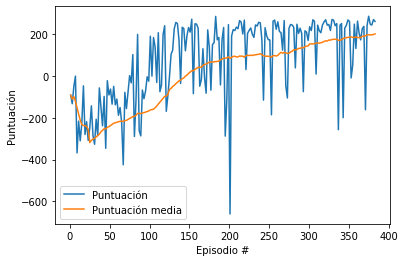

In [ ]:
    plt.plot([i+1 for i in range(0, len(loss[0]), 2)], loss[0][::2],label='Puntuación')
    plt.plot([i+1 for i in range(0, len(loss[1]), 2)], loss[1][::2],label='Puntuación media')
    plt.ylabel('Puntuación')
    plt.xlabel('Episodio #')
    plt.legend()
    plt.show()

Como podemos observar se llega al objetivo antes del episodio 400, concretamente en el 382.